In [1]:
import thermalizer.models.misc as misc
import thermalizer.kolmogorov.simulate as simulate
import thermalizer.kolmogorov.performance as performance
import torch
import seaborn as sns

import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import numpy as np
import kymatio
from kymatio.torch import Scattering2D

from torch import optim
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
sims_cut=-1
steps_cut=1
model_therm=misc.load_model("/scratch/cp3759/thermalizer_data/kolmogorov/model_weights.pt")
test_data=torch.load("/scratch/cp3759/thermalizer_data/kolmogorov/test_suite/all.pt")
print(test_data.shape)
test_data=test_data[:sims_cut,:steps_cut]/model_therm.config["field_std"]
print(test_data.shape)
test_data=test_data.to("cuda")

torch.Size([64, 10000, 64, 64])
torch.Size([63, 1, 64, 64])


100%|██████████| 63/63 [00:26<00:00,  2.41it/s]


Text(0.5, 0, 'Scattering field number')

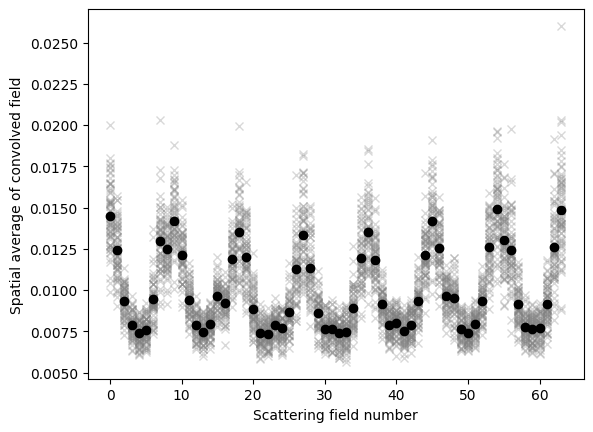

In [3]:
scatt_all=torch.zeros(len(test_data),64)
plt.figure("Scattering coefficients for randomly sampled true Kolmogorov fields")
for aa in tqdm(range(len(test_data))):
    scattering = Scattering2D(J=2, shape=(64,64), max_order=2)
    scattering = scattering.cuda()
    max_iter = 500
    scattering_coefficients = scattering(test_data[aa,0])
    plt.plot(torch.mean(scattering_coefficients[17:],dim=(1,2)).cpu(),"x",color="gray",alpha=0.3)
    scatt_all[aa]=torch.mean(scattering_coefficients[17:],dim=(1,2))
plt.plot(torch.mean(scatt_all,axis=0),"o",color="black")
plt.ylabel("Spatial average of convolved field")
plt.xlabel("Scattering field number")

In [4]:
scattering_objective=torch.mean(scatt_all,axis=0).to(device)

100%|██████████| 99/99 [00:08<00:00, 12.20it/s]


(0.005, 0.027)

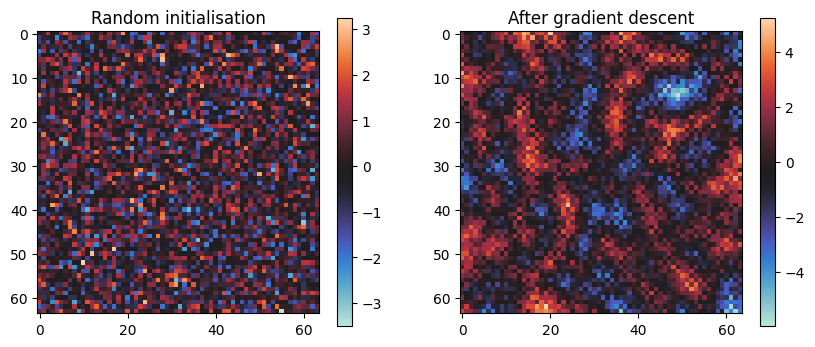

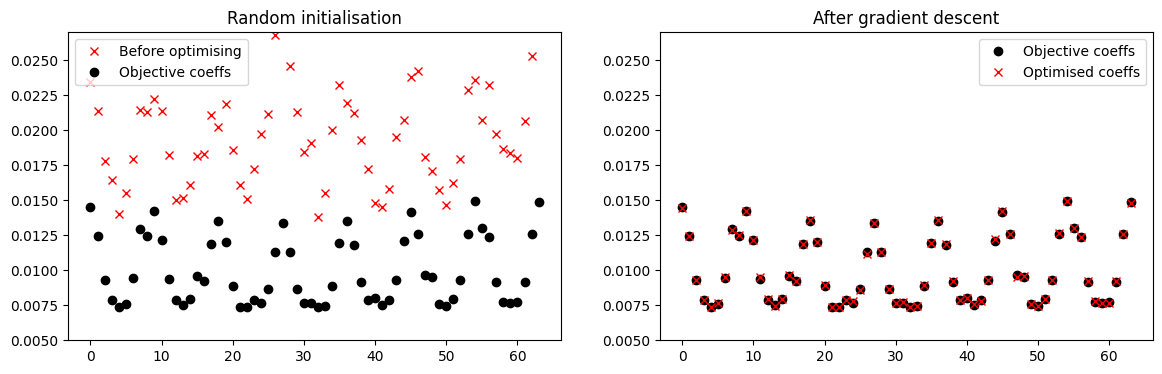

In [5]:
input_tensor = torch.randn((64,64), requires_grad=True, device=device)
init_field=input_tensor.detach().cpu()
new_coefficients = scattering(input_tensor)
init_scats=torch.mean(new_coefficients[17:],axis=(1,2)).detach().cpu()

optimizer = optim.Adam([input_tensor], lr=10)

max_iter=100
for epoch in tqdm(range(1, max_iter)):
    optimizer.zero_grad()
    new_coefficients = scattering(input_tensor)
    loss = F.mse_loss(input=torch.mean(new_coefficients[17:],axis=(1,2)), target=scattering_objective)
    #print("Epoch {}, loss: {}".format(epoch, loss.item()), end="\r")
    loss.backward()
    optimizer.step()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Random initialisation")
plt.imshow(init_field,cmap=sns.cm.icefire)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("After gradient descent")
plt.imshow(input_tensor.detach().cpu(),cmap=sns.cm.icefire)
plt.colorbar()

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.title("Random initialisation")
plt.plot(init_scats,"x",color="red",label="Before optimising")
plt.plot(scattering_objective.detach().cpu(),"o",color="black",label="Objective coeffs")
plt.legend()
plt.ylim(0.005,0.027)
plt.subplot(1,2,2)
plt.title("After gradient descent")
new_coefficients = scattering(input_tensor)
plt.plot(scattering_objective.detach().cpu(),"o",color="black",label="Objective coeffs")
plt.plot(torch.mean(new_coefficients[17:],axis=(1,2)).detach().cpu(),"x",color="red",label="Optimised coeffs")
plt.legend()
plt.ylim(0.005,0.027)